## OBJECT DETECTION NOTEBOOK
This is a testing project developed for the purpose of Object Detection of images
Models used,
01. YOLOV3
02. FRCNN

Later these two models are combined to perform weighted boxes fusion (A method used for merging predictions from multiple models)

### Loading all the required libraries

In [1]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import numpy as np
from ensemble_boxes import weighted_boxes_fusion
import os

/Users/admin/Documents/Object Detection/forOD1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/admin/Documents/Object Detection/forOD1/lib/python3.9/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.9.0` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### Loading the pretrained models for Yolov3 and FRCNN from Model Zoo

In [2]:
yolov3 = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
frcnn = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True)

### Loading a sample image for testing

In [3]:
im_fname="biking.jpg"
from PIL import Image
Img=Image.open(im_fname)
np.shape(Img)

(600, 956, 3)

### Object Detection through the YoloV3 model

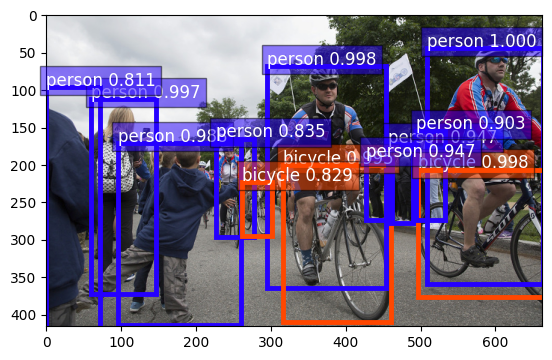

In [4]:
x_yolo, img_yolo = data.transforms.presets.yolo.load_test(im_fname)

class_ids_yolo, scores_yolo, bboxs_yolo = yolov3(x_yolo)

ax_yolo = utils.viz.plot_bbox(img_yolo, bboxs_yolo[0], scores_yolo[0],
                         class_ids_yolo[0], class_names=yolov3.classes)
plt.show()

### Object Detection through the FRCNN model

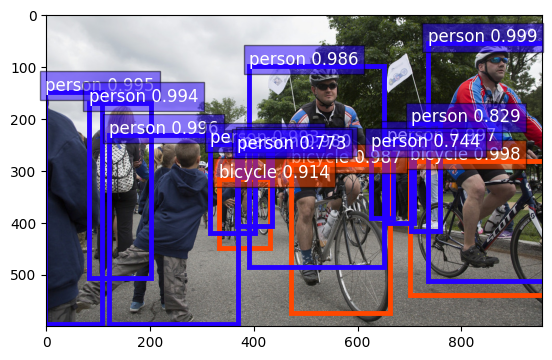

In [5]:
x_frcnn, img_frcnn = data.transforms.presets.rcnn.load_test(im_fname)
class_ids_frcnn, scores_frcnn, bboxes_frcnn = frcnn(x_frcnn)
ax_frcnn = utils.viz.plot_bbox(img_frcnn, bboxes_frcnn[0], scores_frcnn[0], class_ids_frcnn[0], class_names=frcnn.classes)
plt.show()

### Pre Processing the Outputs obtained from the above models to be used for weighted boxes fusion

01. In preprocessing we normalize the our bounding boxes values to use as input for the weighted boxes fusion function
02. Make our arrays match the dimensions required for the function inputs

In [6]:
def normalize_list(pass_list):
    all_values = [val for sublist in pass_list for val in sublist]
    min_val = min(all_values)
    max_val = max(all_values)

    # Normalize the elements
    normalized_list = [[(x - min_val) / (max_val - min_val) for x in sublist] for sublist in pass_list]
    return normalized_list

# Bounding boxes
B1=bboxs_yolo[0].asnumpy().tolist()
B1 = normalize_list(B1)
B2=bboxes_frcnn[0].asnumpy().tolist()
B2 = normalize_list(B2)

# Scores
S1=scores_yolo[0].asnumpy().tolist()
S1 = normalize_list(S1)
S2=scores_frcnn[0].asnumpy().tolist()
S2 = normalize_list(S2)

# Classes
C1=class_ids_yolo[0].asnumpy().tolist()
C2=class_ids_frcnn[0].asnumpy().tolist()


### Weighted Boxes Fusion

In this set, we could do parameter tuning to find out the best values to be used as the input parameters.

In [7]:
boxes_list = [B1,B2]
scores_list = [np.array(S1).flatten(), np.array(S2).flatten()]
labels_list = [np.array(C1).flatten(),np.array(C2).flatten()]

weights = None

iou_thr = 0.6
skip_box_thr = 0.0001
sigma = 0.1

boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)


### Post Processing

01. Here post processing is done to remove all the unwanted boxes by thresholding the score values
02. Denormalize the box values

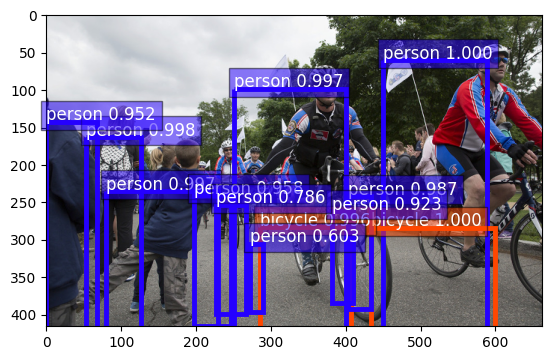

In [8]:
# Threshold value
FINAL_CONF_THRESH=1e-3
res = Img.size
#[W, H, W, H]
res_array = np.array([res[1], res[0], res[1], res[0]])

# Filter out boxes having scores < FINAL_CONF_THRESH
final_scores_ids = np.where(scores > FINAL_CONF_THRESH)[0]
 
final_boxes = boxes[final_scores_ids]
final_scores = scores[final_scores_ids]

# De Normalize Box coordinates in [xmin, ymin, xmax, ymax]
final_boxes = (final_boxes*res_array).clip(min=[0.,0.,0.,0.],
                                                   max=[res[1]-1, res[0]-1, res[1]-1, res[0]-1])
 
final_boxes = final_boxes.astype("int")
# final_boxes[:,2:] = final_boxes[:,2:] - final_boxes[:, :2]
final_boxes=final_boxes.tolist()

# Plotting the Output
ax_frcnn = utils.viz.plot_bbox(img_yolo, final_boxes, final_scores,labels, class_names=frcnn.classes)
plt.show()